# [Multivariate time series forecasting using LSTM](https://github.com/bnsreenu/python_for_microscopists/blob/master/181_multivariate_timeseries_LSTM_GE.py) 

In [8]:
%reset -f
from pprint import pprint
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import rcParams
import seaborn as sns
sns.set()
rcParams['figure.figsize'] = 10,10
from sklearn.preprocessing import StandardScaler 
from functionsAll import lstmMultiSplit

## Data pre-processing.

In [9]:
df = pd.read_csv("../Data/cleanned/zusammen.csv", parse_dates=["date"])
df['dayofyear'] = df['date'].dt.dayofyear
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year
df['weekday'] = df['date'].dt.weekday
df['hour'] = df['date'].dt.hour
df['day'] = df['date'].dt.day
df['week'] = df['date'].dt.week
df.drop(columns=['date','rohwert'], inplace= True)
# Conclude with 11 features, 1 label.
df = df[[ 'wert', 'day', 'month', 'dayofyear', 'year', 'weekday', 'week', 'hour','temp', 'dwpt', 'rhum', 'prcp']]
df.dropna(inplace=True)
df.reset_index(inplace=True, drop=True)

/home/cluster_home/yash/workspace/AutoMLRepo/Auto-ML-On-De-Pollution/autoMLVenv/lib64/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  


## Scale the Training dataset and split it into Train Test Split.

In [10]:
scaler = StandardScaler()
scaler = scaler.fit(df)
scaledDf = scaler.transform(df)
train = scaledDf[:23000]
test = scaledDf[23000:] 

In [11]:
# Verifying the data
# pprint(df[0:1])
# pprint(scaledDf[0:1])
# pprint(scaler.inverse_transform(scaledDf[0]))

In [12]:
trainX, trainY = lstmMultiSplit(df=train, n_past=5, n_future=1)
testX, testY = lstmMultiSplit(df=test, n_past=5, n_future=1)

## Model

In [13]:
# model = Sequential()
# model.add(LSTM(128, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
# model.add(LSTM(64, activation='relu', return_sequences=True))
# model.add(LSTM(32, activation='relu', return_sequences=False))
# model.add(Dropout(0.2))
# model.add(Dense(trainY.shape[1]))

# model.compile(optimizer='adam', loss='mean_squared_error')
from tensorflow import keras
model = keras.models.load_model('../models/ml04/ml04.h5')
model.summary()

# history = model.fit(trainX, trainY, epochs=30, batch_size=14, validation_split=0.1, verbose=1)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 5, 128)            72192     
_________________________________________________________________
lstm_7 (LSTM)                (None, 5, 64)             49408     
_________________________________________________________________
lstm_8 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 134,049
Trainable params: 134,049
Non-trainable params: 0
_________________________________________________________________


In [6]:
rcParams['figure.figsize'] = 10,4
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

NameError: name 'history' is not defined

In [11]:
# model.save('../models/ml04.h5')


In [14]:
prediction = model.predict(testX)

In [15]:
prediction = np.repeat(prediction, 12, axis=-1)
realPrediction = scaler.inverse_transform(prediction)
realPrediction = realPrediction[:,0]
yt = df.query('index >= 23000')
yt = yt['wert']
yt.reset_index(drop=True, inplace=True)

In [16]:
print(f"Train accuracy: {model.evaluate(trainX, trainY,batch_size=64)*100:.2f}%")
print(f"Test accuracy: {model.evaluate(testX, testY,batch_size=64)*100:.2f}%")

360/360 [==============================] - 2s 4ms/step - loss: 0.2437
Train accuracy: 24.37%
12/12 [==============================] - 0s 4ms/step - loss: 0.3169
Test accuracy: 31.69%


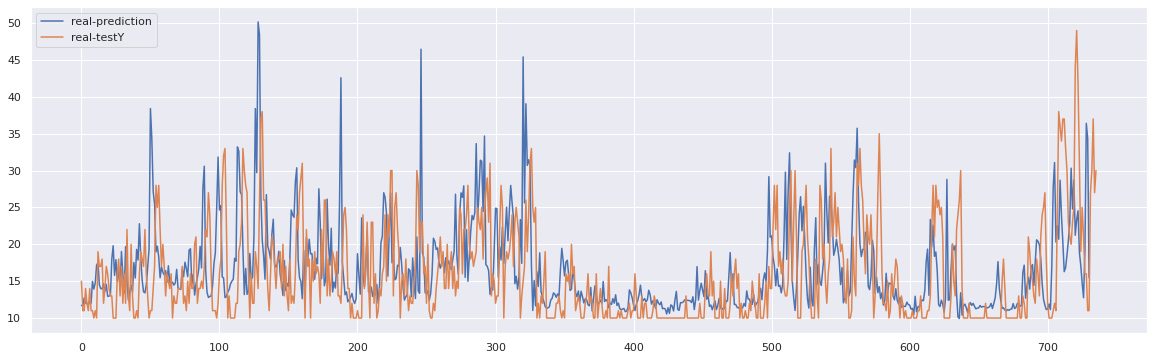

In [17]:
rcParams['figure.figsize'] = 20,6
plt.plot(realPrediction, label='real-prediction')
plt.plot(yt, label='real-testY')
plt.legend() 
plt.show()

In [18]:
pdf = pd.DataFrame(data=realPrediction,columns=['prediction'])
pdf['Real'] = yt
pdf['Error'] = pdf['prediction'] - pdf['Real']

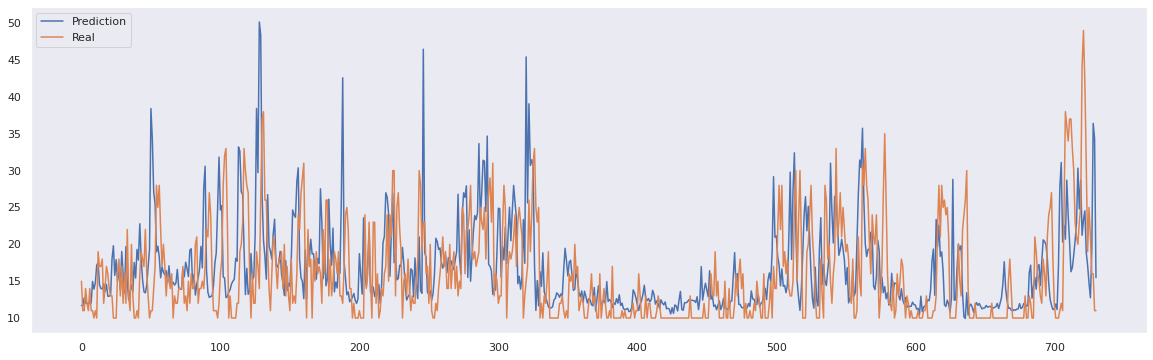

In [19]:
plt.plot(pdf.prediction, label='Prediction')
plt.plot(pdf.Real, label='Real')
plt.legend()
plt.grid()
plt.show()

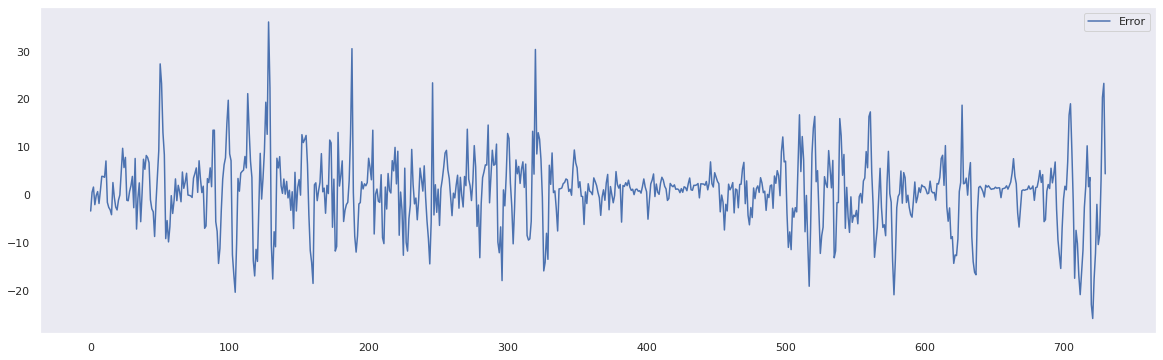

In [20]:
plt.plot(pdf.Error, label='Error')
plt.legend()
plt.grid()
plt.show()

In [22]:
pdf.to_csv('../models/ml04/ml04Predictions.csv', index=False)